<a href="https://colab.research.google.com/github/devanandini0210/zinc_detector/blob/main/Faster_R_CNN_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/Master_Thesis/dataset.zip" -d /content/

Mounted at /content/drive


In [2]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_paths = sorted([
            os.path.join(image_dir, f) for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png'))
        ])
        self.label_paths = [
            os.path.join(label_dir, os.path.splitext(os.path.basename(p))[0] + ".txt")
            for p in self.image_paths
        ]
        self.transforms = transforms or ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
      image = cv2.imread(self.image_paths[idx])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      h, w = image.shape[:2]

      boxes, labels = [], []
      with open(self.label_paths[idx], "r") as f:
          for line in f:
              parts = line.strip().split()
              if len(parts) != 5:
                  continue
              cls, xc, yc, bw, bh = map(float, parts)
              x1 = (xc - bw / 2) * w
              y1 = (yc - bh / 2) * h
              x2 = (xc + bw / 2) * w
              y2 = (yc + bh / 2) * h

              if x2 <= x1 or y2 <= y1:  # skip invalid boxes
                  continue

              boxes.append([x1, y1, x2, y2])
              labels.append(int(cls) + 1)

      if len(boxes) == 0:
          return None  # skip samples with no valid boxes

      target = {
          "boxes": torch.tensor(boxes, dtype=torch.float32),
          "labels": torch.tensor(labels, dtype=torch.int64),
          "image_id": torch.tensor(idx)
      }

      image = self.transforms(image)
      return image, target



In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [4]:
train_img_dir = "/content/dataset/images/train"
train_lbl_dir = "/content/dataset/labels/train"
val_img_dir   = "/content/dataset/images/val"
val_lbl_dir   = "/content/dataset/labels/val"

train_dataset = YoloDataset(train_img_dir, train_lbl_dir, transforms=ToTensor())
val_dataset   = YoloDataset(val_img_dir, val_lbl_dir, transforms=ToTensor())

In [5]:
from torch.utils.data import DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2).to(device)

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.005, momentum=0.9, weight_decay=0.0005)

model.train()

best_loss= float('inf')

for epoch in range(20):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

    #Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "fasterrcnn_best.pth")
        print(f"Best model saved (loss: {best_loss:.4f})")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]


Epoch 1 — Avg Loss: 0.3803
Best model saved (loss: 0.3803)
Epoch 2 — Avg Loss: 0.2783
Best model saved (loss: 0.2783)
Epoch 3 — Avg Loss: 0.2419
Best model saved (loss: 0.2419)
Epoch 4 — Avg Loss: 0.2062
Best model saved (loss: 0.2062)
Epoch 5 — Avg Loss: 0.1881
Best model saved (loss: 0.1881)
Epoch 6 — Avg Loss: 0.1722
Best model saved (loss: 0.1722)
Epoch 7 — Avg Loss: 0.1652
Best model saved (loss: 0.1652)
Epoch 8 — Avg Loss: 0.1526
Best model saved (loss: 0.1526)
Epoch 9 — Avg Loss: 0.1410
Best model saved (loss: 0.1410)
Epoch 10 — Avg Loss: 0.1317
Best model saved (loss: 0.1317)
Epoch 11 — Avg Loss: 0.1256
Best model saved (loss: 0.1256)
Epoch 12 — Avg Loss: 0.1223
Best model saved (loss: 0.1223)
Epoch 13 — Avg Loss: 0.1174
Best model saved (loss: 0.1174)
Epoch 14 — Avg Loss: 0.1133
Best model saved (loss: 0.1133)
Epoch 15 — Avg Loss: 0.1096
Best model saved (loss: 0.1096)
Epoch 16 — Avg Loss: 0.1148
Epoch 17 — Avg Loss: 0.1047
Best model saved (loss: 0.1047)
Epoch 18 — Avg Loss: 

In [7]:
from google.colab import files
files.download("fasterrcnn_best.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
test_img_dir = "/content/dataset/images/test"
test_lbl_dir = "/content/dataset/labels/test"

test_dataset = YoloDataset(test_img_dir, test_lbl_dir, transforms=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [9]:
model.load_state_dict(torch.load("fasterrcnn_best.pth"))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
from torchvision.ops import box_iou
import numpy as np

def evaluate_frcnn(model, loader, device, iou_thresh=0.5):
    tp_total, fp_total, fn_total = 0, 0, 0
    iou_scores = []

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            preds = outputs[0]
            target = targets[0]

            gt_boxes = target['boxes'].cpu()
            pred_boxes = preds['boxes'].cpu()
            scores = preds['scores'].cpu()

            if len(pred_boxes) == 0:
                fn_total += len(gt_boxes)
                continue

            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt = set()
            matched_pred = set()

            for pred_idx in range(ious.size(0)):
                max_iou, gt_idx = ious[pred_idx].max(0)
                if max_iou >= iou_thresh and gt_idx.item() not in matched_gt:
                    tp_total += 1
                    matched_gt.add(gt_idx.item())
                    matched_pred.add(pred_idx)
                    iou_scores.append(max_iou.item())

            fp_total += len(pred_boxes) - len(matched_pred)
            fn_total += len(gt_boxes) - len(matched_gt)

    precision = tp_total / (tp_total + fp_total + 1e-6)
    recall = tp_total / (tp_total + fn_total + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"TP: {tp_total}, FP: {fp_total}, FN: {fn_total}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"Avg IoU: {np.mean(iou_scores):.4f}" if iou_scores else "Avg IoU: N/A")


In [18]:
evaluate_frcnn(model, test_loader, device)

TP: 1278, FP: 206, FN: 69
Precision: 0.8612, Recall: 0.9488, F1-score: 0.9029
Avg IoU: 0.8864


In [19]:
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(model, loader, device, class_map={1: "zinc"}, score_thresh=0.5, num_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, _ in loader:
            image = images[0].to(device)
            output = model([image])[0]

            img_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy().copy()

            for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                if score < score_thresh:
                    continue
                x1, y1, x2, y2 = map(int, box)
                cls_name = class_map.get(label.item(), str(label.item()))
                cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img_np, f"{cls_name} {score:.2f}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            plt.figure(figsize=(8, 8))
            plt.imshow(img_np)
            plt.axis("off")
            plt.title("Faster R-CNN Prediction")
            plt.show()

            shown += 1
            if shown >= num_images:
                break


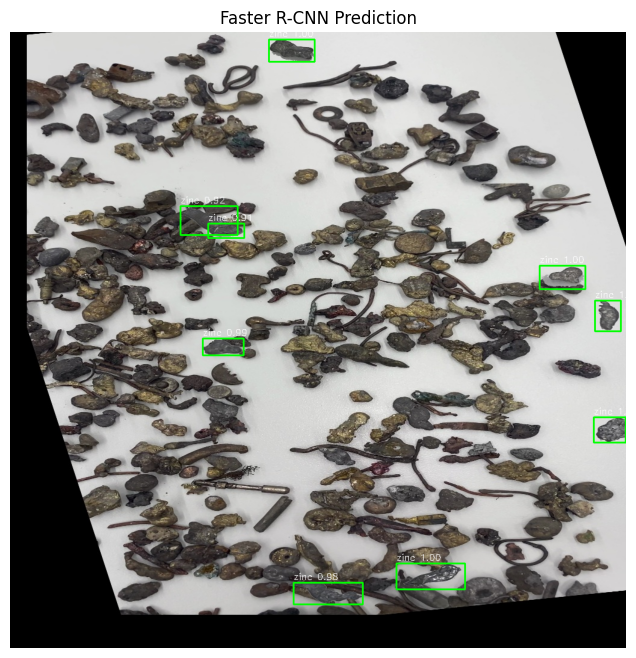

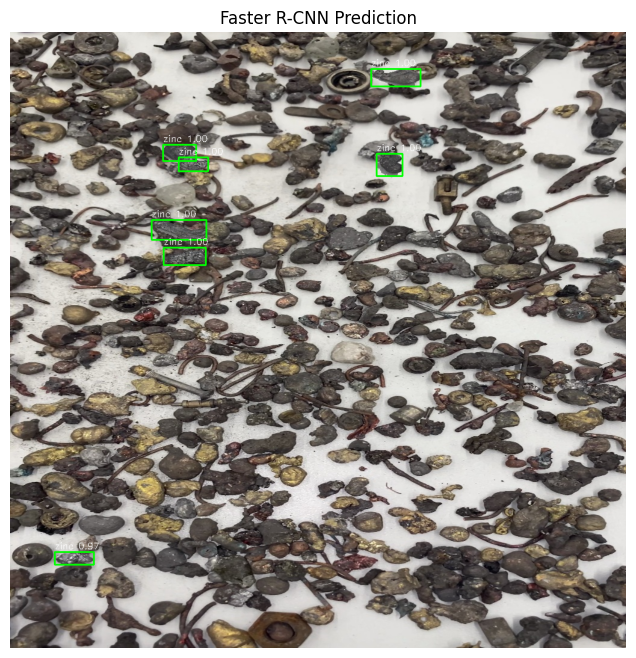

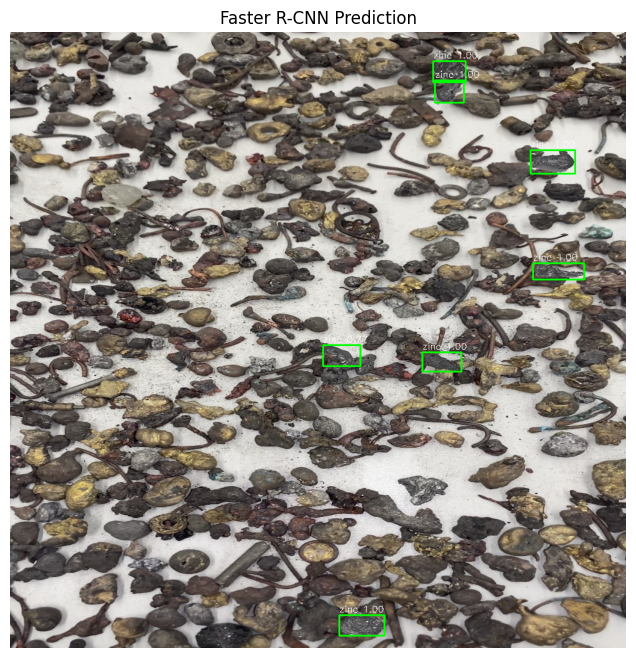

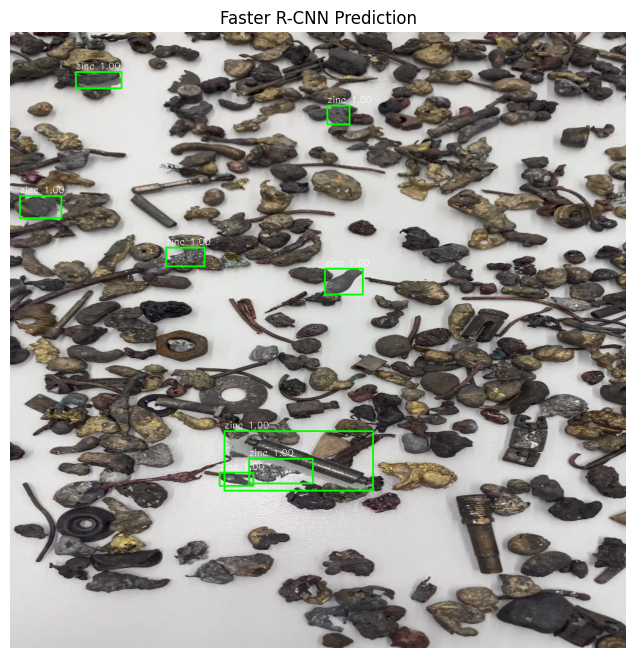

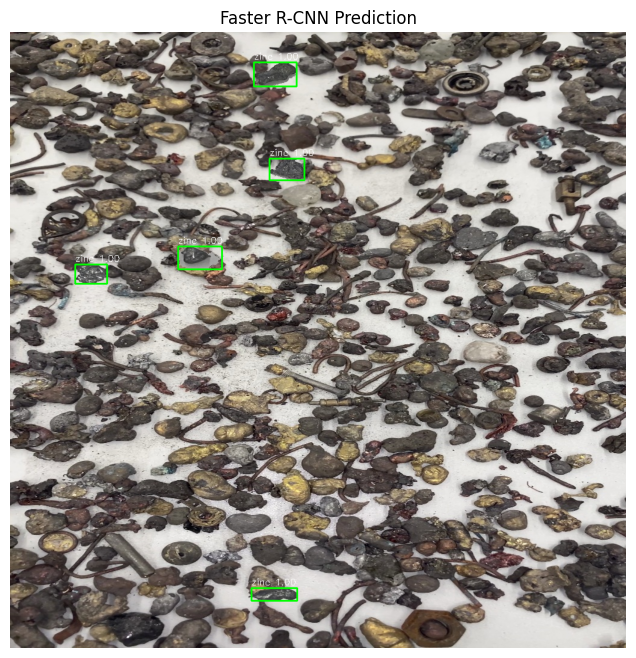

In [20]:
visualize_predictions(model, test_loader, device)

In [21]:
import matplotlib.pyplot as plt

def plot_confidence_histogram(model, loader, device, num_bins=20):
    model.eval()
    scores = []

    with torch.no_grad():
        for images, _ in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for output in outputs:
                scores.extend(output['scores'].cpu().numpy())

    plt.hist(scores, bins=num_bins, range=(0, 1), color='skyblue', edgecolor='black')
    plt.title("Confidence Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def compute_pr_curve(model, loader, device, iou_thresh=0.5):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt = target['boxes'].cpu()
                scores = output['scores'].cpu().numpy()
                preds = output['boxes'].cpu()

                ious = box_iou(preds, gt)
                matched_gt = set()
                for i, iou_vec in enumerate(ious):
                    max_iou = iou_vec.max().item()
                    y_scores.append(scores[i])
                    y_true.append(1 if max_iou >= iou_thresh else 0)

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.plot(recall, precision, label=f"AP = {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_confusion_matrix(model, loader, device, iou_thresh=0.5):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt = target['boxes'].cpu()
                preds = output['boxes'].cpu()
                scores = output['scores'].cpu().numpy()

                ious = box_iou(preds, gt)
                matched_gt = set()
                for i, iou_vec in enumerate(ious):
                    max_iou, idx = iou_vec.max(0)
                    if max_iou >= iou_thresh and idx.item() not in matched_gt:
                        y_true.append(1)  # object
                        y_pred.append(1)  # detected
                        matched_gt.add(idx.item())
                    else:
                        y_true.append(0)
                        y_pred.append(1)  # false positive

                for j in range(len(gt)):
                    if j not in matched_gt:
                        y_true.append(1)
                        y_pred.append(0)  # false negative

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Detected", "Missed"], yticklabels=["Object", "No Object"])
    plt.title("Confusion Matrix")
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.show()


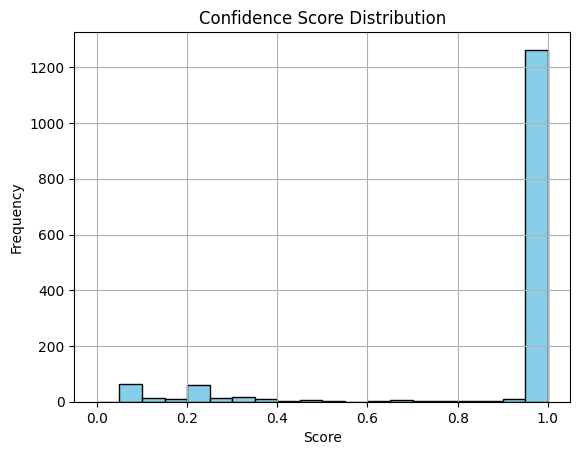

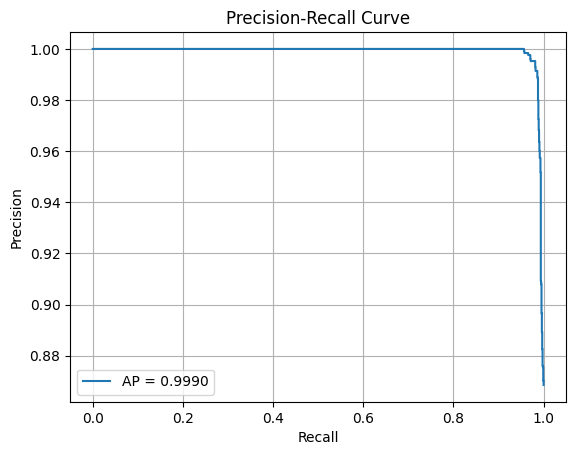

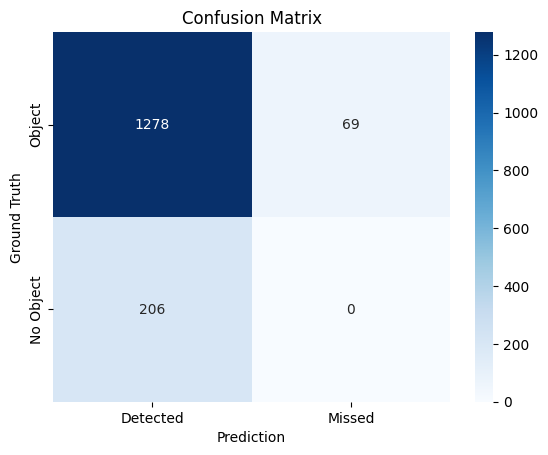

In [24]:
plot_confidence_histogram(model, test_loader, device)
compute_pr_curve(model, test_loader, device)
compute_confusion_matrix(model, test_loader, device)